In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #makes the display bars longer and spread out 100% across the screen width


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

!pwd
!whoami
!date

/ihme/homes/nicoly/vivarium_research_ciff_sam/model_validation/model2
nicoly
Tue Aug 10 01:29:33 PDT 2021


# 2.5: STUNTING (RISK validation)

## stunting risk vv

In [3]:
%cd /ihme/costeffectiveness/results/vivarium_ciff_sam/v2.5_stunting/ciff_sam/2021_08_05_16_17_12/count_data
%ls

/ihme/costeffectiveness/results/vivarium_ciff_sam/v2.5_stunting/ciff_sam/2021_08_05_16_17_12/count_data
deaths.csv                     population.csv                 ylds.csv
deaths.hdf                     population.hdf                 ylds.hdf
disease_state_person_time.csv  wasting_state_person_time.csv  ylls.csv
disease_state_person_time.hdf  wasting_state_person_time.hdf  ylls.hdf
disease_transition_count.csv   wasting_transition_count.csv
disease_transition_count.hdf   wasting_transition_count.hdf


In [4]:
#make directory to store outputs

#%mkdir /home/j/Project/simulation_science/ciff_malnutrition/verification_and_validation/v2.5_stunting
#%chmod 777 v2.5_stunting

In [5]:
master_dir = '/home/j/Project/simulation_science/ciff_malnutrition/'
sim_result_dir = '/ihme/costeffectiveness/results/vivarium_ciff_sam/v2.5_stunting/ciff_sam/2021_08_05_16_17_12/count_data/' 
output_dir = master_dir + f'verification_and_validation/v2.5_stunting/'

In [6]:
#everything we need to validate stunting prevalence is in 'disease state person time'

disease_state_explore = pd.read_csv(sim_result_dir + 'disease_state_person_time.csv')
#deaths_explore.stunting_state.unique()
disease_state_explore

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,value,stunting_state,age
0,0,female,2022,diarrheal_diseases,state_person_time,29,baseline,43.489391,cat4,early_neonatal
1,1,female,2022,diarrheal_diseases,state_person_time,29,baseline,0.000000,cat3,early_neonatal
2,2,female,2022,diarrheal_diseases,state_person_time,29,baseline,0.000000,cat2,early_neonatal
3,3,female,2022,diarrheal_diseases,state_person_time,29,baseline,0.000000,cat1,early_neonatal
...,...,...,...,...,...,...,...,...,...,...
17276,17276,male,2026,susceptible_to_measles,state_person_time,946,baseline,121118.023272,cat4,2_to_4
17277,17277,male,2026,susceptible_to_measles,state_person_time,946,baseline,67325.987680,cat3,2_to_4
17278,17278,male,2026,susceptible_to_measles,state_person_time,946,baseline,66608.265572,cat2,2_to_4
17279,17279,male,2026,susceptible_to_measles,state_person_time,946,baseline,63010.346338,cat1,2_to_4


## LOAD SIM DATA

In [7]:
def load_sim_count_data(sim_result_dir: str):
    columns = ['age', 'sex', 'year', 'input_draw', 'scenario', 'measure', 'stunting_state']
    df = {}
    fnames = ['disease_state_person_time']
    for fname in fnames:
        df[fname] = pd.read_csv(sim_result_dir + fname + '.csv', index_col=0)
        # get aggregated results if stratifications exist
        if 'cause' in df[fname].columns:
            df[fname] = df[fname].groupby(columns + ['cause']).value.sum().reset_index()
        else:
            df[fname] = df[fname].groupby(columns).value.sum().reset_index()
    return df

df = load_sim_count_data(sim_result_dir)

### STUNTING STATE PERSON TIME

In [8]:
df['stunting_person_time'] = df['disease_state_person_time'].loc[
    df['disease_state_person_time'].cause.isin(['diarrheal_diseases','susceptible_to_diarrheal_diseases']) #17280/3 = 5756 rows
].groupby(['age','sex','year','input_draw','scenario','measure', 'stunting_state']).sum().reset_index()

df['stunting_person_time'] 

,age,sex,year,input_draw,scenario,measure,stunting_state,value
0,1-5_months,female,2022,29,baseline,state_person_time,cat1,1773.377139
1,1-5_months,female,2022,29,baseline,state_person_time,cat2,4759.605749
2,1-5_months,female,2022,29,baseline,state_person_time,cat3,9053.603012
3,1-5_months,female,2022,29,baseline,state_person_time,cat4,28554.000000
...,...,...,...,...,...,...,...,...
2876,late_neonatal,male,2026,946,baseline,state_person_time,cat1,0.000000
2877,late_neonatal,male,2026,946,baseline,state_person_time,cat2,0.000000
2878,late_neonatal,male,2026,946,baseline,state_person_time,cat3,0.000000
2879,late_neonatal,male,2026,946,baseline,state_person_time,cat4,6238.913073


In [9]:
#numerators of stunting prevalence 

person_time_stunting_cat4 = df['stunting_person_time'].query('stunting_state == "cat4"')
person_time_stunting_cat3 = df['stunting_person_time'].query('stunting_state == "cat3"')
person_time_stunting_cat2 = df['stunting_person_time'].query('stunting_state == "cat2"')
person_time_stunting_cat1 = df['stunting_person_time'].query('stunting_state == "cat1"')

In [10]:
person_time_stunting_cat1

#6 ages x 2 sexes x 5 years x 12 draws = 720

,age,sex,year,input_draw,scenario,measure,stunting_state,value
0,1-5_months,female,2022,29,baseline,state_person_time,cat1,1773.377139
4,1-5_months,female,2022,223,baseline,state_person_time,cat1,1668.093087
8,1-5_months,female,2022,232,baseline,state_person_time,cat1,1781.709788
12,1-5_months,female,2022,357,baseline,state_person_time,cat1,1563.278576
...,...,...,...,...,...,...,...,...
2864,late_neonatal,male,2026,650,baseline,state_person_time,cat1,0.000000
2868,late_neonatal,male,2026,680,baseline,state_person_time,cat1,0.000000
2872,late_neonatal,male,2026,829,baseline,state_person_time,cat1,0.000000
2876,late_neonatal,male,2026,946,baseline,state_person_time,cat1,0.000000


#### TOTAL PERSON TIME

In [11]:
# sum of value of disease person time is the total person time. This is the denominator for prevalence of stunting.

df['risk_person_time'] = df['disease_state_person_time'].loc[
    df['disease_state_person_time'].cause.isin(['diarrheal_diseases','susceptible_to_diarrheal_diseases'])
].groupby(['age','sex','year','input_draw','scenario','measure']).sum().reset_index()

df['risk_person_time']['cause'] = 'all_causes'

df['risk_person_time'].value.sum()

61808761.71389458

In [12]:
#denominator data frame

df['risk_person_time'] #all person time for each age, sex, year and input draw (6 x 2 x 5 x 12 = 720)

,age,sex,year,input_draw,scenario,measure,value,cause
0,1-5_months,female,2022,29,baseline,state_person_time,44140.585900,all_causes
1,1-5_months,female,2022,223,baseline,state_person_time,43787.301848,all_causes
2,1-5_months,female,2022,232,baseline,state_person_time,43689.518138,all_causes
3,1-5_months,female,2022,357,baseline,state_person_time,43650.172485,all_causes
...,...,...,...,...,...,...,...,...
716,late_neonatal,male,2026,650,baseline,state_person_time,6258.131417,all_causes
717,late_neonatal,male,2026,680,baseline,state_person_time,6279.897331,all_causes
718,late_neonatal,male,2026,829,baseline,state_person_time,6308.962355,all_causes
719,late_neonatal,male,2026,946,baseline,state_person_time,6238.913073,all_causes


In [13]:
# check code to see it is total dd and sus dd person time (61136436.774811774 from model 2.4)

disease_state_explore.loc[
    (disease_state_explore.cause.isin(['diarrheal_diseases','susceptible_to_diarrheal_diseases']))].value.sum()

61808761.71389459

In [14]:
disease_state_explore.loc[
    (disease_state_explore.stunting_state.isin(['cat1','cat2','cat3','cat4']))].value.sum()/3 # correct as this should be 3x more

61808761.71389458

In [15]:
disease_state_explore

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,value,stunting_state,age
0,0,female,2022,diarrheal_diseases,state_person_time,29,baseline,43.489391,cat4,early_neonatal
1,1,female,2022,diarrheal_diseases,state_person_time,29,baseline,0.000000,cat3,early_neonatal
2,2,female,2022,diarrheal_diseases,state_person_time,29,baseline,0.000000,cat2,early_neonatal
3,3,female,2022,diarrheal_diseases,state_person_time,29,baseline,0.000000,cat1,early_neonatal
...,...,...,...,...,...,...,...,...,...,...
17276,17276,male,2026,susceptible_to_measles,state_person_time,946,baseline,121118.023272,cat4,2_to_4
17277,17277,male,2026,susceptible_to_measles,state_person_time,946,baseline,67325.987680,cat3,2_to_4
17278,17278,male,2026,susceptible_to_measles,state_person_time,946,baseline,66608.265572,cat2,2_to_4
17279,17279,male,2026,susceptible_to_measles,state_person_time,946,baseline,63010.346338,cat1,2_to_4


In [16]:
df['disease_state_person_time'] #same table as disease_state_explore but better organized

,age,sex,year,input_draw,scenario,measure,stunting_state,cause,value
0,1-5_months,female,2022,29,baseline,state_person_time,cat1,diarrheal_diseases,176.783025
1,1-5_months,female,2022,29,baseline,state_person_time,cat1,lower_respiratory_infections,9.258042
2,1-5_months,female,2022,29,baseline,state_person_time,cat1,measles,3.514031
3,1-5_months,female,2022,29,baseline,state_person_time,cat1,susceptible_to_diarrheal_diseases,1596.594114
...,...,...,...,...,...,...,...,...,...
17276,late_neonatal,male,2026,946,baseline,state_person_time,cat4,measles,0.000000
17277,late_neonatal,male,2026,946,baseline,state_person_time,cat4,susceptible_to_diarrheal_diseases,5937.741273
17278,late_neonatal,male,2026,946,baseline,state_person_time,cat4,susceptible_to_lower_respiratory_infections,6230.951403
17279,late_neonatal,male,2026,946,baseline,state_person_time,cat4,susceptible_to_measles,6238.913073


In [17]:
pd.read_csv(sim_result_dir + 'population.csv', index_col=0)

,measure,input_draw,scenario,value
0,total_population,29,baseline,2089439.0
1,total_population,223,baseline,2090788.0
2,total_population,232,baseline,2090287.0
3,total_population,357,baseline,2088756.0
...,...,...,...,...
56,total_population_untracked,650,baseline,988204.0
57,total_population_untracked,680,baseline,990901.0
58,total_population_untracked,829,baseline,991915.0
59,total_population_untracked,946,baseline,988882.0


## CALCULATE SIM MEASURES

In [18]:
def get_measure(data: pd.DataFrame, denom: pd.DataFrame, entity: str):
    """
    rate per PY among source population
    note the numerator is 'data' and denominator is df['person_time']
    """
    
    result = ((data
               .set_index(['age', 'sex', 'year', 'input_draw', 'scenario', 'measure', entity])
               .div(denom.drop(columns=['measure', 'cause'])
                    .set_index(['age', 'sex', 'year', 'input_draw', 'scenario'])))
              .reset_index())
    
    result['age_group'] = np.where(result['age'] == 'early_neonatal', 1,
                              np.where(result['age'] == 'late_neonatal', 2,
                                       np.where(result['age'] == '1-5_months',3,
                                                np.where(result['age'] == '6-11_months',4,
                                                         np.where(result['age'] == '12_to_23_months',5,
                                                         6)))))
    
    result_summary = (result
                      .groupby(['age_group', 'sex', 'year', 'scenario', 'measure', entity])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
    
    return result_summary

In [19]:
df.keys()

dict_keys(['disease_state_person_time', 'stunting_person_time', 'risk_person_time'])

### PREVALENCE

In [20]:
# risk prevalence
prevalence_stunting_cat4 = get_measure(person_time_stunting_cat4, df['risk_person_time'], 'stunting_state')
prevalence_stunting_cat3 = get_measure(person_time_stunting_cat3, df['risk_person_time'], 'stunting_state')
prevalence_stunting_cat2 = get_measure(person_time_stunting_cat2, df['risk_person_time'], 'stunting_state')
prevalence_stunting_cat1 = get_measure(person_time_stunting_cat1, df['risk_person_time'], 'stunting_state')

In [21]:
prevalence_stunting_cat4

,age_group,sex,year,scenario,measure,stunting_state,mean,2.5%,97.5%
0,1,female,2022,baseline,state_person_time,cat4,1.000000,1.000000,1.000000
1,1,female,2023,baseline,state_person_time,cat4,1.000000,1.000000,1.000000
2,1,female,2024,baseline,state_person_time,cat4,1.000000,1.000000,1.000000
3,1,female,2025,baseline,state_person_time,cat4,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...
56,6,male,2023,baseline,state_person_time,cat4,0.390237,0.373282,0.412552
57,6,male,2024,baseline,state_person_time,cat4,0.390536,0.373832,0.412563
58,6,male,2025,baseline,state_person_time,cat4,0.390579,0.373447,0.412997
59,6,male,2026,baseline,state_person_time,cat4,0.390757,0.373322,0.413755


# ARTIFACT

In [22]:
#filepath

%cd /ihme/costeffectiveness/artifacts/vivarium_ciff_sam/
%ls

/ihme/costeffectiveness/artifacts/vivarium_ciff_sam
backup-2.hdf  backup.hdf  ethiopia.hdf


In [23]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf', filter_terms=['year_start == 2020', f'age_end <= 5'])

In [24]:
#load population structure

art_stunting = art.load('risk_factor.child_stunting.exposure').reset_index()

In [25]:
art_stunting

,sex,age_start,age_end,year_start,year_end,parameter,draw_0,draw_1,draw_2,draw_3,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,0.0,0.019178,2020,2021,cat1,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Female,0.0,0.019178,2020,2021,cat2,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Female,0.0,0.019178,2020,2021,cat3,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Female,0.0,0.019178,2020,2021,cat4,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,Male,2.0,5.000000,2020,2021,cat1,0.199662,0.209233,0.22169,0.203711,...,0.214385,0.205179,0.202380,0.215713,0.213310,0.214450,0.207650,0.221595,0.208892,0.200710
45,Male,2.0,5.000000,2020,2021,cat2,0.210250,0.204566,0.19471,0.205063,...,0.204269,0.206087,0.200517,0.202198,0.212113,0.207015,0.190666,0.189080,0.198103,0.205074
46,Male,2.0,5.000000,2020,2021,cat3,0.208679,0.205280,0.19376,0.206368,...,0.201163,0.207330,0.206132,0.201582,0.209284,0.203994,0.193587,0.184929,0.199927,0.206286
47,Male,2.0,5.000000,2020,2021,cat4,0.381409,0.380921,0.38984,0.384859,...,0.380183,0.381405,0.390971,0.380507,0.365293,0.374542,0.408097,0.404396,0.393077,0.387930


In [26]:
print(art)

Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
cause
	all_causes
		cause_specific_mortality_rate
	diarrheal_diseases
		prevalence
		incidence_rate
		remission_rate
		disability_weight
		excess_mortality_rate
		cause_specific_mortality_rate
		restrictions
	measles
		prevalence
		incidence_rate
		disability_weight
		excess_mortality_rate
		cause_specific_mortality_rate
		restrictions
	lower_respiratory_infections
		prevalence
		incidence_rate
		remission_rate
		disability_weight
		excess_mortality_rate
		cause_specific_mortality_rate
		restrictions
	protein_energy_malnutrition
		excess_mortality_rate
		cause_specific_mortality_rate
		restrictions
covariate
	live_births_by_sex
		estimate
sequela
	moderate_acute_malnutrition
		disability_weight
	severe_acute_malnutrition
		disability_weight
risk_factor
	child_wasting
		distribution
		categories
		exposure
		rel

In [27]:
def load_stunting_prev(cat):
    data = art.load('risk_factor.child_stunting.exposure')
    
    data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()

    data['age'] = 0
    
    data['age'] = np.where(data['age_start'] == 0, 'early_neonatal', #1
                                            np.where(data['age_end'] == 0.5, '1-5_months', #3
                                                     np.where(data['age_start'] == 0.5, '6-11_months', #4
                                                              np.where(data['age_start'] == 1, '12_to_23_months',  #5
                                                                       np.where(data['age_start'] == 2, '2_to_4',       #6
                                                                       'late_neonatal'))))) #2
        
    data['age_group'] = np.where(data['age'] == 'early_neonatal', 1,
                                   np.where(data['age'] == 'late_neonatal', 2,
                                            np.where(data['age'] == '1-5_months', 3, 
                                                     np.where(data['age'] == '6-11_months', 4, 
                                                              np.where(data['age'] == '12_to_23_months', 5,
                                    6)))))


    data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
    #subset to cat
    risk_dict = {
        'cat1':'stunting_cat1',
        'cat2':'stunting_cat2',
        'cat3':'stunting_cat3',
        'cat4':'stunting_cat4'
    }
    data['risk'] = data.parameter.map(risk_dict)
    data = data.loc[data.parameter==cat].drop(columns=['parameter'])
    data['measure'] = 'prevalence'
    
    return data

In [28]:
stunting_cat1_prev = load_stunting_prev('cat1')
stunting_cat2_prev = load_stunting_prev('cat2')
stunting_cat3_prev = load_stunting_prev('cat3')
stunting_cat4_prev = load_stunting_prev('cat4')

In [29]:
stunting_cat1_prev

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age,age_group,risk,measure
0,female,0.000000,0.019178,2020,2021,0.000000,0.000000,0.000000,early_neonatal,1,stunting_cat1,prevalence
4,female,0.019178,0.076712,2020,2021,0.000000,0.000000,0.000000,late_neonatal,2,stunting_cat1,prevalence
8,female,0.076712,0.500000,2020,2021,0.041628,0.032961,0.050297,1-5_months,3,stunting_cat1,prevalence
12,female,0.500000,1.000000,2020,2021,0.062041,0.050808,0.073045,6-11_months,4,stunting_cat1,prevalence
...,...,...,...,...,...,...,...,...,...,...,...,...
32,male,0.076712,0.500000,2020,2021,0.063966,0.052277,0.076181,1-5_months,3,stunting_cat1,prevalence
36,male,0.500000,1.000000,2020,2021,0.102615,0.088472,0.119155,6-11_months,4,stunting_cat1,prevalence
40,male,1.000000,2.000000,2020,2021,0.201386,0.182045,0.221568,12_to_23_months,5,stunting_cat1,prevalence
44,male,2.000000,5.000000,2020,2021,0.206411,0.186052,0.226343,2_to_4,6,stunting_cat1,prevalence


In [30]:
stunting_cat1_prev.year_start.unique()

array([2020])

In [31]:
data = art.load('risk_factor.child_stunting.exposure')
data

draw_0    draw_1  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.000000  0.000000   
                                              cat2       0.000000  0.000000   
                                              cat3       0.000000  0.000000   
                                              cat4       1.000000  1.000000   
...                                                           ...       ...   
Male   2.0       5.000000 2020       2021     cat1       0.199662  0.209233   
                                              cat2       0.210250  0.204566   
                                              cat3       0.208679  0.205280   
                                              cat4       0.381409  0.380921   

                                                          draw_2    draw_3  \
sex    age_start age_end  year_start year_end parameter                      
Female 0.0       0.019178 2020       2021     cat1       0.00000  0.000000   
                                              cat2       0.00000  0.000000   
                                              cat3       0.00000  0.000000   
                                              cat4       1.00000  1.000000   
...                                                          ...       ...   
Male   2.0       5.000000 2020       2021     cat1       0.22169  0.203711   
                                              cat2       0.19471  0.205063   
                                              cat3       0.19376  0.206368   
                                              cat4       0.38984  0.384859   

                                                           draw_4    draw_5  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.000000  0.000000   
                                              cat2       0.000000  0.000000   
                                              cat3       0.000000  0.000000   
                                              cat4       1.000000  1.000000   
...                                                           ...       ...   
Male   2.0       5.000000 2020       2021     cat1       0.215731  0.217537   
                                              cat2       0.209395  0.193768   
                                              cat3       0.199769  0.191531   
                                              cat4       0.375106  0.397165   

                                                           draw_6    draw_7  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.000000  0.000000   
                                              cat2       0.000000  0.000000   
                                              cat3       0.000000  0.000000   
                                              cat4       1.000000  1.000000   
...                                                           ...       ...   
Male   2.0       5.000000 2020       2021     cat1       0.188558  0.223472   
                                              cat2       0.217215  0.209372   
                                              cat3       0.221159  0.198343   
                                              cat4       0.373068  0.368813   

                                                           draw_8    draw_9  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.000000  0.000000   
                                              cat2       0.000000  0.000000   
                                              cat3       0.000000  0.000000   
                                              cat4       1.000000  1.000000   
...                                                           ...       ...   
Male   2.0       5.000000 2020       

In [32]:
df['disease_state_person_time'].input_draw.unique()

array([ 29, 223, 232, 357, 394, 524, 602, 629, 650, 680, 829, 946])

In [33]:
draws = [f'draw_{i}' for i in df['disease_state_person_time'].input_draw.unique()]
data[draws]

draw_29  draw_223  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.000000  0.000000   
                                              cat2       0.000000  0.000000   
                                              cat3       0.000000  0.000000   
                                              cat4       1.000000  1.000000   
...                                                           ...       ...   
Male   2.0       5.000000 2020       2021     cat1       0.230180  0.195246   
                                              cat2       0.185556  0.215283   
                                              cat3       0.182668  0.217508   
                                              cat4       0.401596  0.371964   

                                                         draw_232  draw_357  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.000000  0.000000   
                                              cat2       0.000000  0.000000   
                                              cat3       0.000000  0.000000   
                                              cat4       1.000000  1.000000   
...                                                           ...       ...   
Male   2.0       5.000000 2020       2021     cat1       0.188931  0.202507   
                                              cat2       0.212985  0.216901   
                                              cat3       0.221385  0.214799   
                                              cat4       0.376699  0.365793   

                                                         draw_394  draw_524  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.000000  0.000000   
                                              cat2       0.000000  0.000000   
                                              cat3       0.000000  0.000000   
                                              cat4       1.000000  1.000000   
...                                                           ...       ...   
Male   2.0       5.000000 2020       2021     cat1       0.226430  0.200048   
                                              cat2       0.192492  0.202288   
                                              cat3       0.190122  0.209303   
                                              cat4       0.390955  0.388361   

                                                         draw_602  draw_629  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.000000  0.000000   
                                              cat2       0.000000  0.000000   
                                              cat3       0.000000  0.000000   
                                              cat4       1.000000  1.000000   
...                                                           ...       ...   
Male   2.0       5.000000 2020       2021     cat1       0.222409  0.213768   
                                              cat2       0.188310  0.185614   
                                              cat3       0.186141  0.191704   
                                              cat4       0.403140  0.408915   

                                                         draw_650  draw_680  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.000000  0.000000   
                                              cat2       0.000000  0.000000   
                                              cat3       0.000000  0.000000   
                                              cat4       1.000000  1.000000   
...                                                           ...       ...   
Male   2.0       5.000000

In [34]:
def load_all_stunting_prev(draw_numbers=None):
    data = art.load('risk_factor.child_stunting.exposure')
    if draw_numbers is not None:
        draws = [f'draw_{i}' for i in draw_numbers]
        data = data[draws]
    
    data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()

    data['age'] = 0
    
    data['age'] = np.where(data['age_start'] == 0, 'early_neonatal', #1
                                            np.where(data['age_end'] == 0.5, '1-5_months', #3
                                                     np.where(data['age_start'] == 0.5, '6-11_months', #4
                                                              np.where(data['age_start'] == 1, '12_to_23_months',  #5
                                                                       np.where(data['age_start'] == 2, '2_to_4',       #6
                                                                       'late_neonatal'))))) #2
        
    data['age_group'] = np.where(data['age'] == 'early_neonatal', 1,
                                   np.where(data['age'] == 'late_neonatal', 2,
                                            np.where(data['age'] == '1-5_months', 3, 
                                                     np.where(data['age'] == '6-11_months', 4, 
                                                              np.where(data['age'] == '12_to_23_months', 5,
                                    6)))))


    data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
    #subset to cat
    risk_dict = {
        'cat1':'stunting_cat1',
        'cat2':'stunting_cat2',
        'cat3':'stunting_cat3',
        'cat4':'stunting_cat4'
    }
    data['risk'] = data.parameter.map(risk_dict)
    data = data.drop(columns=['parameter'])
    data['measure'] = 'prevalence'
    
    return data

art_stunting_prev = load_all_stunting_prev(draw_numbers=df['disease_state_person_time'].input_draw.unique())
art_stunting_prev

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age,age_group,risk,measure
0,female,0.0,0.019178,2020,2021,0.000000,0.000000,0.000000,early_neonatal,1,stunting_cat1,prevalence
1,female,0.0,0.019178,2020,2021,0.000000,0.000000,0.000000,early_neonatal,1,stunting_cat2,prevalence
2,female,0.0,0.019178,2020,2021,0.000000,0.000000,0.000000,early_neonatal,1,stunting_cat3,prevalence
3,female,0.0,0.019178,2020,2021,1.000000,1.000000,1.000000,early_neonatal,1,stunting_cat4,prevalence
...,...,...,...,...,...,...,...,...,...,...,...,...
44,male,2.0,5.000000,2020,2021,0.207535,0.190667,0.229149,2_to_4,6,stunting_cat1,prevalence
45,male,2.0,5.000000,2020,2021,0.204366,0.185572,0.221539,2_to_4,6,stunting_cat2,prevalence
46,male,2.0,5.000000,2020,2021,0.204944,0.183623,0.220319,2_to_4,6,stunting_cat3,prevalence
47,male,2.0,5.000000,2020,2021,0.383156,0.364887,0.407326,2_to_4,6,stunting_cat4,prevalence


# PLOT

In [35]:
def summarize_df(data: pd.DataFrame, entity: str):
    result = data.reset_index()
    
    result['age_group'] = np.where(result['age'] == 'early_neonatal', 1,
                              np.where(result['age'] == 'late_neonatal', 2,
                                       np.where(result['age'] == '1-5_months',3,
                                                np.where(result['age'] == '6-11_months',4,
                                                         np.where(result['age'] == '12_to_23_months',5,
                                                         6)))))
    
    group_cols = ['age_group', 'sex', 'year', 'scenario', 'measure'] + [entity]
    
    result_summary = (result
                      .groupby(group_cols)
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
    return result_summary

In [37]:
stunting_pt_df = summarize_df(df['stunting_person_time'], entity = 'stunting_state')


pt_stunting_cat1_df = summarize_df(person_time_stunting_cat1, entity = 'stunting_state')
pt_stunting_cat2_df = summarize_df(person_time_stunting_cat2, entity = 'stunting_state')
pt_stunting_cat3_df = summarize_df(person_time_stunting_cat3, entity = 'stunting_state')
pt_stunting_cat4_df = summarize_df(person_time_stunting_cat4, entity = 'stunting_state')



In [38]:
person_time_stunting_cat1

,age,sex,year,input_draw,scenario,measure,stunting_state,value
0,1-5_months,female,2022,29,baseline,state_person_time,cat1,1773.377139
4,1-5_months,female,2022,223,baseline,state_person_time,cat1,1668.093087
8,1-5_months,female,2022,232,baseline,state_person_time,cat1,1781.709788
12,1-5_months,female,2022,357,baseline,state_person_time,cat1,1563.278576
...,...,...,...,...,...,...,...,...
2864,late_neonatal,male,2026,650,baseline,state_person_time,cat1,0.000000
2868,late_neonatal,male,2026,680,baseline,state_person_time,cat1,0.000000
2872,late_neonatal,male,2026,829,baseline,state_person_time,cat1,0.000000
2876,late_neonatal,male,2026,946,baseline,state_person_time,cat1,0.000000


In [39]:
pt_stunting_cat1_df 

,age_group,sex,year,scenario,measure,stunting_state,mean,2.5%,97.5%
0,1,female,2022,baseline,state_person_time,cat1,0.000000,0.000000,0.000000
1,1,female,2023,baseline,state_person_time,cat1,0.000000,0.000000,0.000000
2,1,female,2024,baseline,state_person_time,cat1,0.000000,0.000000,0.000000
3,1,female,2025,baseline,state_person_time,cat1,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
56,6,male,2023,baseline,state_person_time,cat1,62719.909423,57028.863142,69820.919644
57,6,male,2024,baseline,state_person_time,cat1,63928.578143,57842.058042,71226.709856
58,6,male,2025,baseline,state_person_time,cat1,64437.255533,58008.455647,71760.857700
59,6,male,2026,baseline,state_person_time,cat1,64585.029546,58027.133641,72024.425736


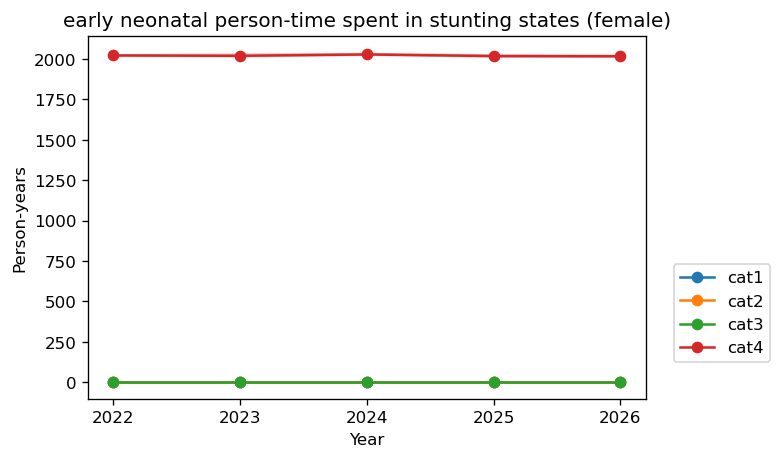

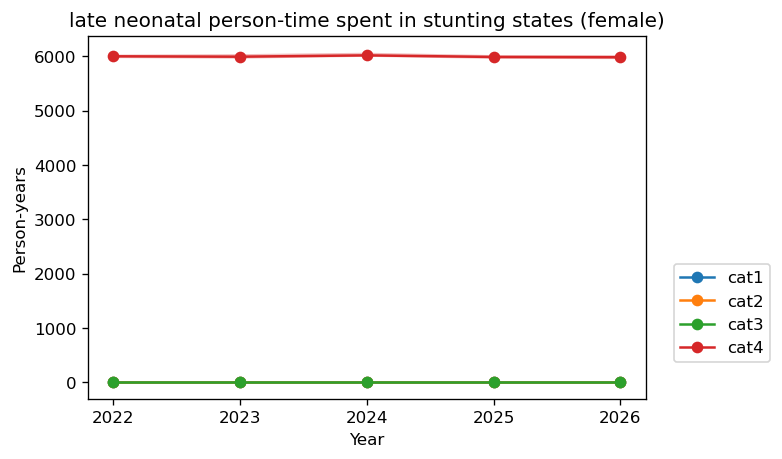

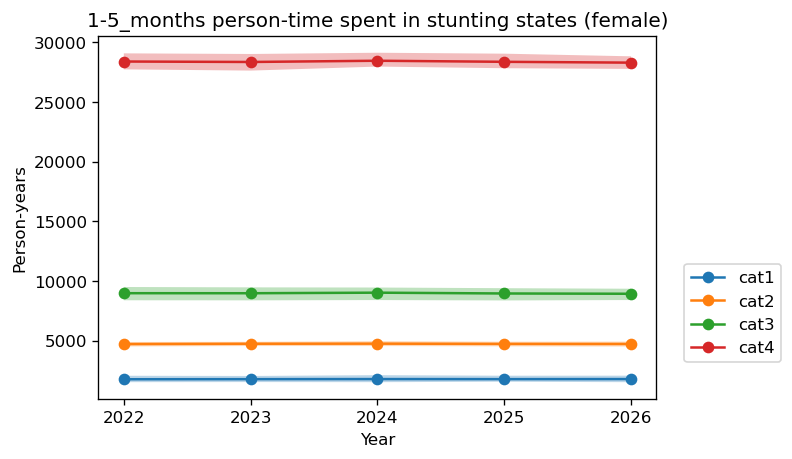

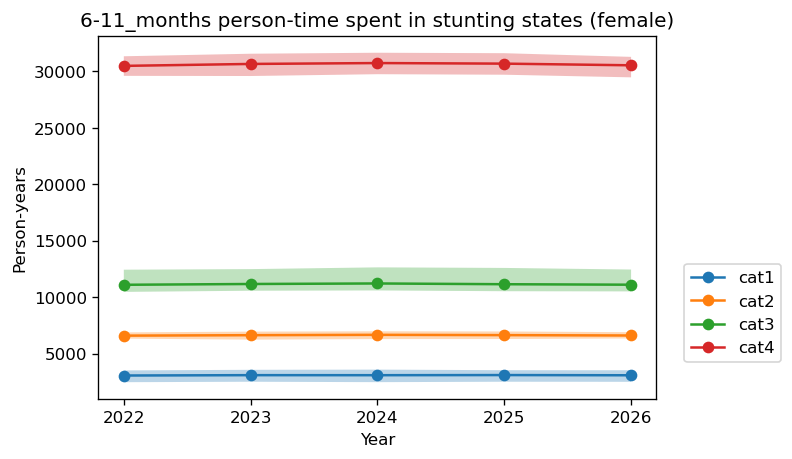

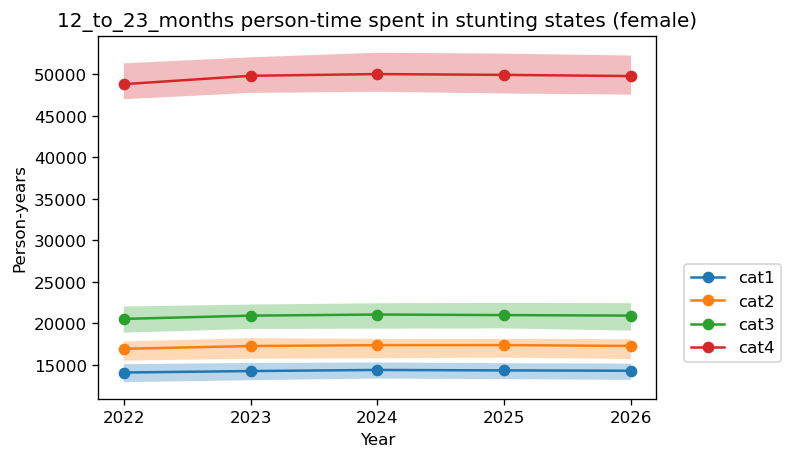

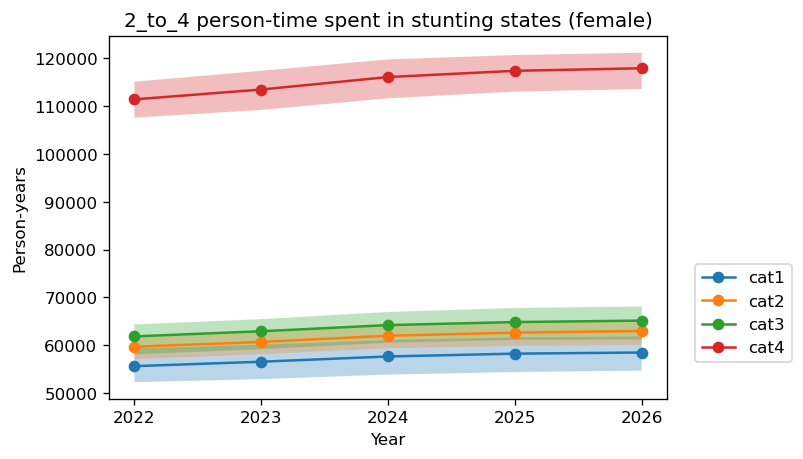

In [40]:
def plot_stunting_pt_over_time(df, sex, age_group):
    
    df.year = df.year.astype(int)
    state = df.stunting_state.iloc[0]
    
    #{1: 'early_neonatal', 2: 'late_neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    age_map = {1:'early neonatal',2:'late neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    age = age_map[age_group]
    
    plt.figure(figsize=(6, 4), dpi=120)
    for stunting_state in df.stunting_state.unique():
        sub = df.loc[(df.sex==sex) & (df.age_group==age_group) & (df.stunting_state==stunting_state)]
        plt.plot(sub['year'], sub['mean'], marker='o', label=stunting_state)
        plt.fill_between(sub['year'], sub['2.5%'], sub['97.5%'], alpha=.3)

    plt.legend(loc=(1.05, .1))
    plt.xlabel('Year')
    plt.ylabel('Person-years')
    plt.xticks(ticks = range(df.year.min(), df.year.max()+1))#, labels = ['early neonatal', 'late neonatal', 'post neonatal', '1 to 4'], rotation = 45) 
    plt.title(f'{age} person-time spent in stunting states ({sex})')

for age_group in pt_stunting_cat4_df.age_group.unique():
    plot_stunting_pt_over_time(stunting_pt_df, sex = 'female', age_group = age_group)

In [41]:
def plot_sim_stunting(sim_data: pd.DataFrame, sex: str, sim_measure: str):
           
    ## add age label
    age_labels = {1:'early neonatal',2:'late neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    sim_data['age_label'] = sim_data.age_group.map(age_labels)
    
    
    plt.figure(figsize=(6, 4), dpi=120)
    
    for year in sim_data.year.unique():
        sim_sub = sim_data[(sim_data.scenario == 'baseline') & 
                           (sim_data.year == year) & 
                           (sim_data.sex == sex)]
        plt.plot(sim_sub['age_group'], sim_sub['mean'], marker='o', label=year)
        plt.fill_between(sim_sub['age_group'], sim_sub['2.5%'], sim_sub['97.5%'], alpha=.3)
    
    plt.title(f'{sim_measure}, {sex}')
    plt.xlabel('Age')
    plt.xticks(ticks = [1, 2, 3, 4, 5, 6], labels = ['early neonatal', 'late neonatal', '1-5mo', '6-11mo', '1-2y', '2-4y'], rotation = 45)
          
    plt.legend(loc=(1.05, .1))
    plt.grid()
    

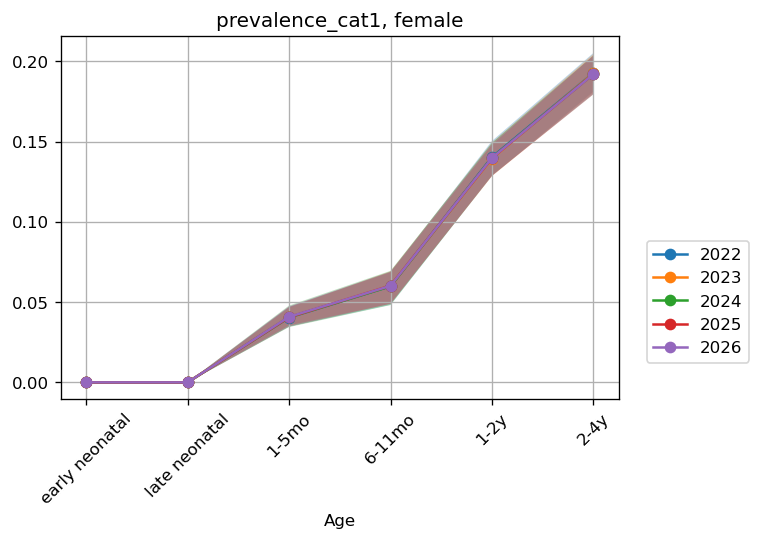

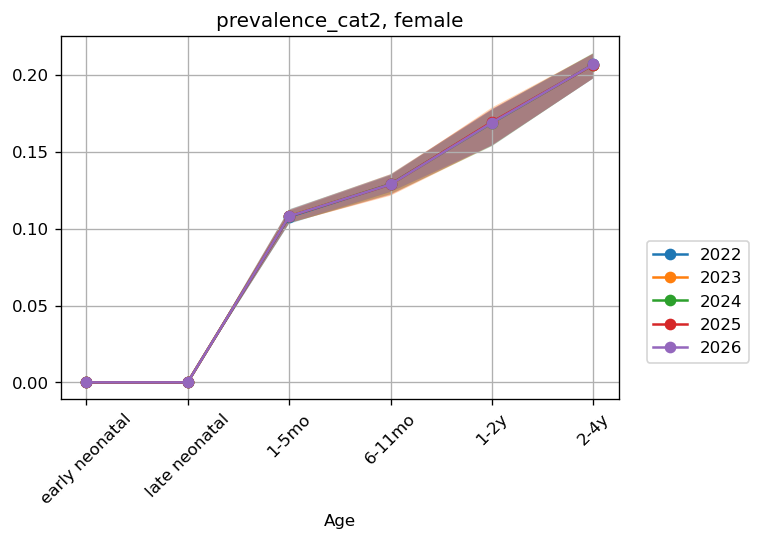

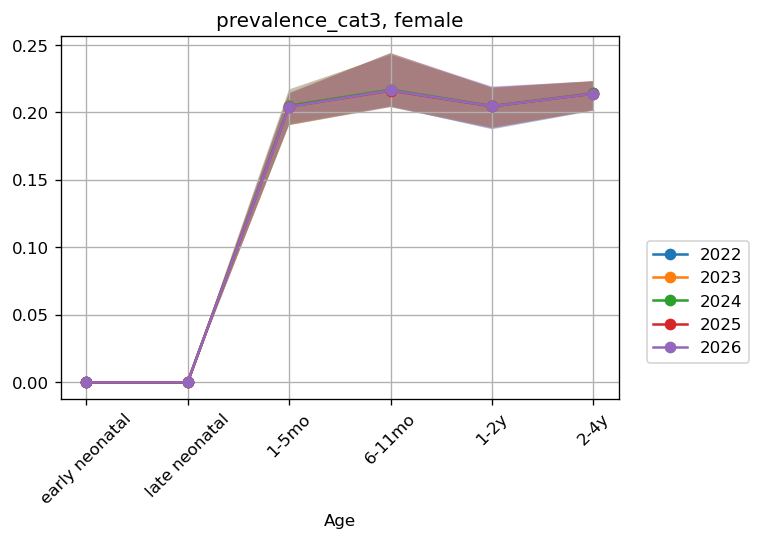

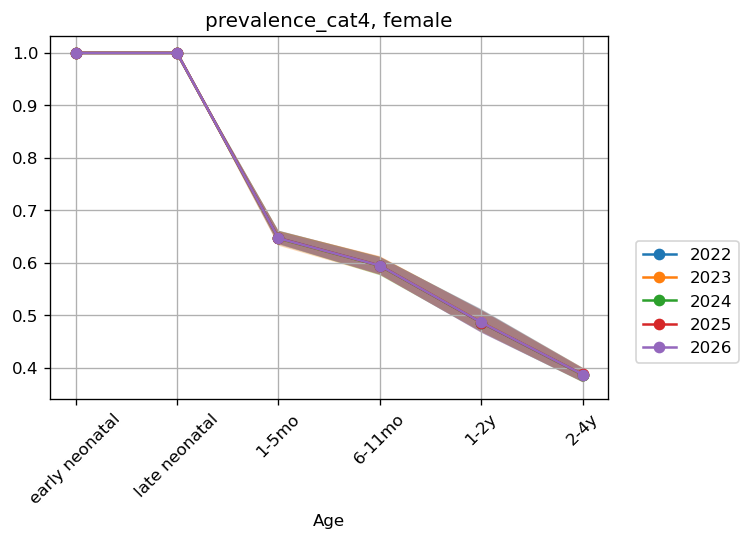

In [42]:
plot_sim_stunting(prevalence_stunting_cat1, sex = 'female', sim_measure = 'prevalence_cat1')
plot_sim_stunting(prevalence_stunting_cat2, sex = 'female', sim_measure = 'prevalence_cat2')
plot_sim_stunting(prevalence_stunting_cat3, sex = 'female', sim_measure = 'prevalence_cat3')
plot_sim_stunting(prevalence_stunting_cat4, sex = 'female', sim_measure = 'prevalence_cat4')

In [45]:
art_stunting_prev.query("risk=='stunting_cat1'")

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age,age_group,risk,measure
0,female,0.000000,0.019178,2020,2021,0.000000,0.000000,0.000000,early_neonatal,1,stunting_cat1,prevalence
4,female,0.019178,0.076712,2020,2021,0.000000,0.000000,0.000000,late_neonatal,2,stunting_cat1,prevalence
8,female,0.076712,0.500000,2020,2021,0.040613,0.035224,0.047429,1-5_months,3,stunting_cat1,prevalence
12,female,0.500000,1.000000,2020,2021,0.060576,0.050498,0.067780,6-11_months,4,stunting_cat1,prevalence
...,...,...,...,...,...,...,...,...,...,...,...,...
32,male,0.076712,0.500000,2020,2021,0.063468,0.055233,0.069244,1-5_months,3,stunting_cat1,prevalence
36,male,0.500000,1.000000,2020,2021,0.097562,0.082158,0.113689,6-11_months,4,stunting_cat1,prevalence
40,male,1.000000,2.000000,2020,2021,0.197732,0.183668,0.209228,12_to_23_months,5,stunting_cat1,prevalence
44,male,2.000000,5.000000,2020,2021,0.207535,0.190667,0.229149,2_to_4,6,stunting_cat1,prevalence


In [ ]:
prevalence_stunting_cat1

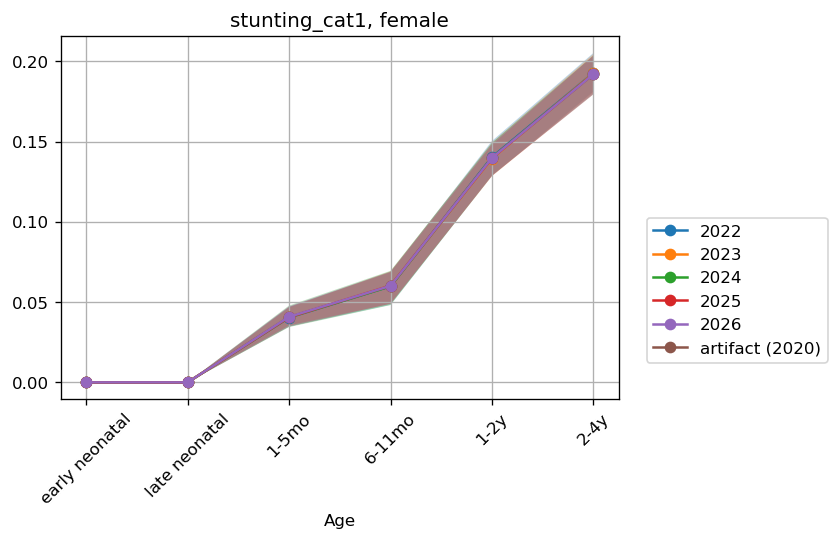

In [48]:
def plot_sim_vs_art_stunting(sim_data: pd.DataFrame, art_data: pd.DataFrame, sex: str, sim_measure: str):
           
    ## add age label
    age_labels = {1:'early neonatal',2:'late neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    sim_data['age_label'] = sim_data.age_group.map(age_labels)
    
    
    plt.figure(figsize=(6, 4), dpi=120)
    
    for year in sim_data.year.unique():
        sim_sub = sim_data[(sim_data.scenario == 'baseline') & 
                           (sim_data.year == year) & 
                           (sim_data.sex == sex)]
        plt.plot(sim_sub['age_group'], sim_sub['mean'], marker='o', label=year)
        plt.fill_between(sim_sub['age_group'], sim_sub['2.5%'], sim_sub['97.5%'], alpha=.3)
        
    art_sub = art_data.query("sex==@sex")
    plt.plot(art_sub['age_group'], art_sub['mean'], marker='o', label="artifact (2020)")
    plt.fill_between(art_sub['age_group'], art_sub['2.5%'], art_sub['97.5%'], alpha=.3)
    
    plt.title(f'{sim_measure}, {sex}')
    plt.xlabel('Age')
    plt.xticks(ticks = [1, 2, 3, 4, 5, 6], labels = ['early neonatal', 'late neonatal', '1-5mo', '6-11mo', '1-2y', '2-4y'], rotation = 45)
          
    plt.legend(loc=(1.05, .1))
    plt.grid()

plot_sim_vs_art_stunting(prevalence_stunting_cat1, art_stunting_prev.query("risk=='sam'"), sex = 'female', sim_measure = 'stunting_cat1')

# Plot sim vs. all 1000 draws in artifact

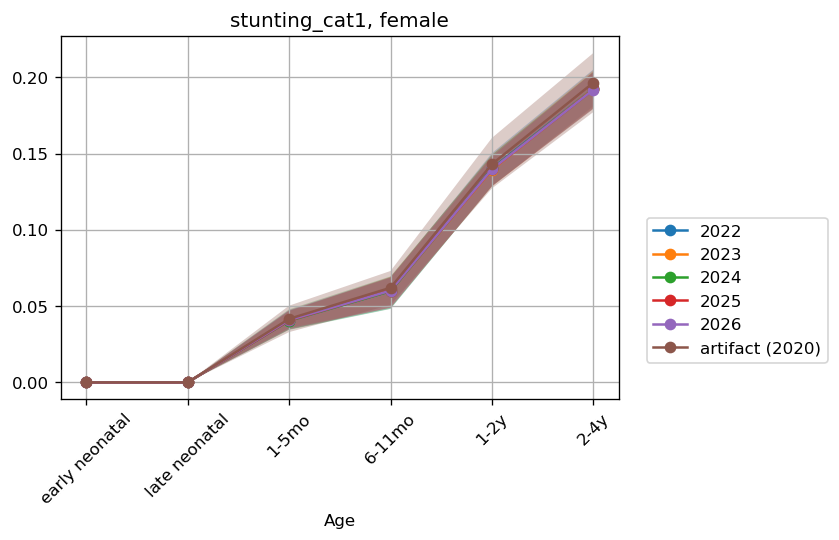

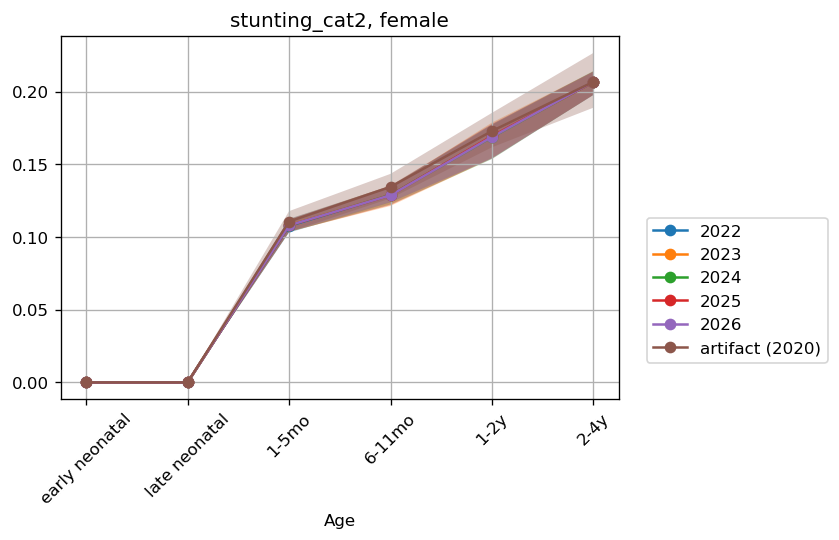

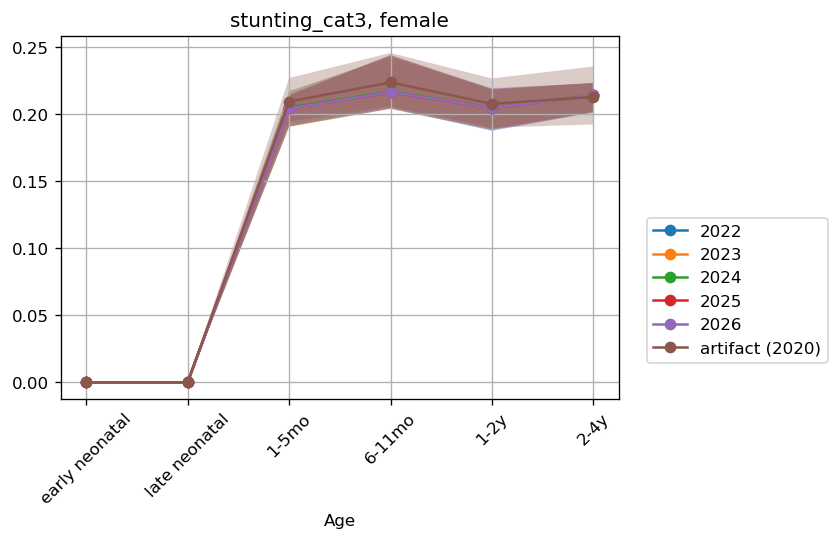

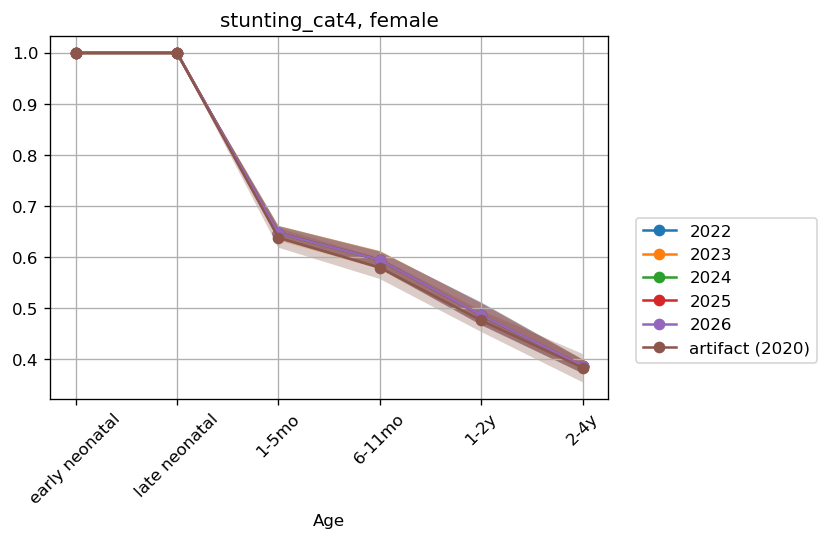

In [49]:
# plot_sim_vs_art_wasting(prevalence_sam, wasting_prev.query("risk=='sam'"), sex = 'female', sim_measure = 'prevalence_sam')

plot_sim_vs_art_stunting(prevalence_stunting_cat1, stunting_cat1_prev, sex = 'female', sim_measure = 'stunting_cat1')
plot_sim_vs_art_stunting(prevalence_stunting_cat2, stunting_cat2_prev, sex = 'female', sim_measure = 'stunting_cat2')
plot_sim_vs_art_stunting(prevalence_stunting_cat3, stunting_cat3_prev, sex = 'female', sim_measure = 'stunting_cat3')
plot_sim_vs_art_stunting(prevalence_stunting_cat4, stunting_cat4_prev, sex = 'female', sim_measure = 'stunting_cat4')

In [50]:
output_dir

'/home/j/Project/simulation_science/ciff_malnutrition/verification_and_validation/v2.5_stunting/'

In [51]:
ls /share/scratch/users/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/v2.5_stunting/

ls: cannot access /share/scratch/users/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/v2.5_stunting/: No such file or directory


In [52]:
art_stunting_prev['risk'].unique()

array(['stunting_cat1', 'stunting_cat2', 'stunting_cat3', 'stunting_cat4'],
      dtype=object)

In [54]:
prevalence_stunting_cat1

,age_group,sex,year,scenario,measure,stunting_state,mean,2.5%,97.5%,age_label
0,1,female,2022,baseline,state_person_time,cat1,0.000000,0.000000,0.000000,early neonatal
1,1,female,2023,baseline,state_person_time,cat1,0.000000,0.000000,0.000000,early neonatal
2,1,female,2024,baseline,state_person_time,cat1,0.000000,0.000000,0.000000,early neonatal
3,1,female,2025,baseline,state_person_time,cat1,0.000000,0.000000,0.000000,early neonatal
...,...,...,...,...,...,...,...,...,...,...
56,6,male,2023,baseline,state_person_time,cat1,0.203943,0.185613,0.226232,2_to_4
57,6,male,2024,baseline,state_person_time,cat1,0.203465,0.184714,0.226159,2_to_4
58,6,male,2025,baseline,state_person_time,cat1,0.203173,0.183791,0.226035,2_to_4
59,6,male,2026,baseline,state_person_time,cat1,0.203081,0.183677,0.226177,2_to_4


In [55]:
sim_stunting_prev = (
    pd.concat([prevalence_stunting_cat1, prevalence_stunting_cat2, prevalence_stunting_cat3, prevalence_stunting_cat4], ignore_index=True)
    .assign(
        risk=lambda df: df['stunting_state'].map(
            {'cat1': 'severe_stunting',
             'cat2': 'moderate_stunting',
             'cat3': 'mild_stunting',
             'cat4': 'tmrel_stunting'
            })
           )
)
sim_stunting_prev

,age_group,sex,year,scenario,measure,stunting_state,mean,2.5%,97.5%,age_label,risk
0,1,female,2022,baseline,state_person_time,cat1,0.000000,0.000000,0.000000,early neonatal,severe_stunting
1,1,female,2023,baseline,state_person_time,cat1,0.000000,0.000000,0.000000,early neonatal,severe_stunting
2,1,female,2024,baseline,state_person_time,cat1,0.000000,0.000000,0.000000,early neonatal,severe_stunting
3,1,female,2025,baseline,state_person_time,cat1,0.000000,0.000000,0.000000,early neonatal,severe_stunting
...,...,...,...,...,...,...,...,...,...,...,...
236,6,male,2023,baseline,state_person_time,cat4,0.390237,0.373282,0.412552,2_to_4,tmrel_stunting
237,6,male,2024,baseline,state_person_time,cat4,0.390536,0.373832,0.412563,2_to_4,tmrel_stunting
238,6,male,2025,baseline,state_person_time,cat4,0.390579,0.373447,0.412997,2_to_4,tmrel_stunting
239,6,male,2026,baseline,state_person_time,cat4,0.390757,0.373322,0.413755,2_to_4,tmrel_stunting


# Plot sim vs. artifact with draws filtered to those in sim

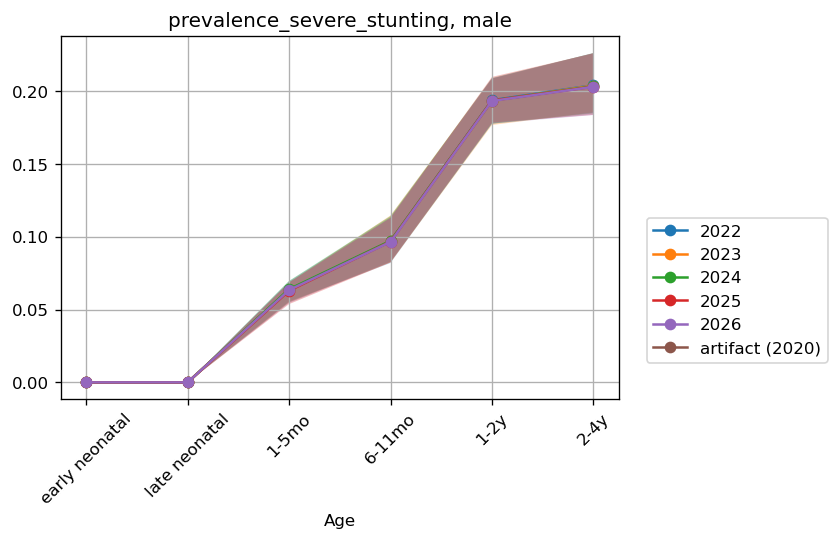

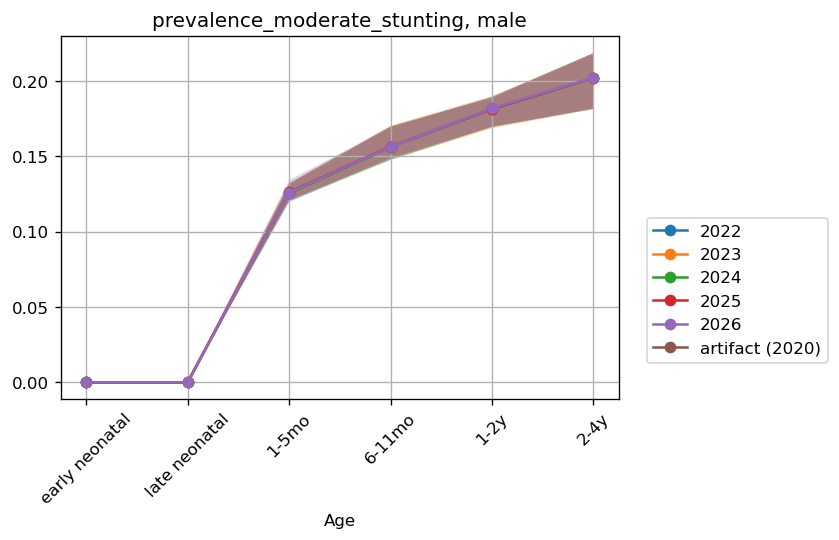

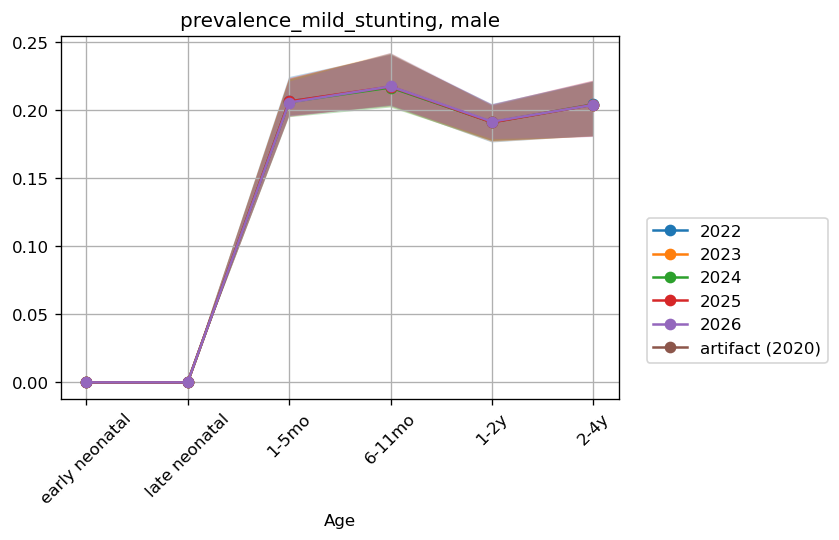

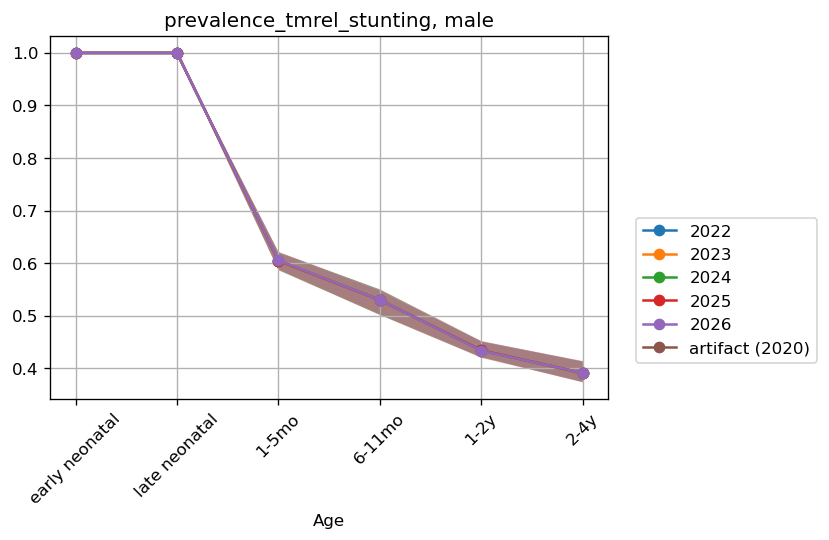

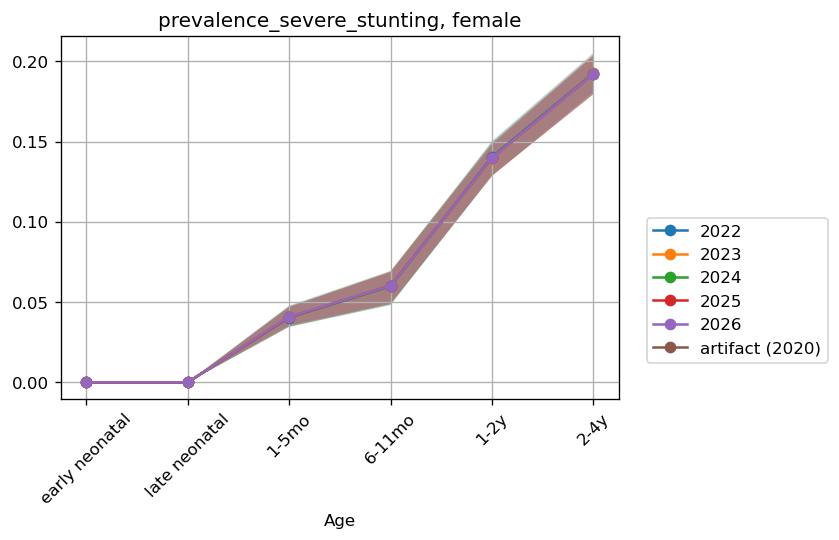

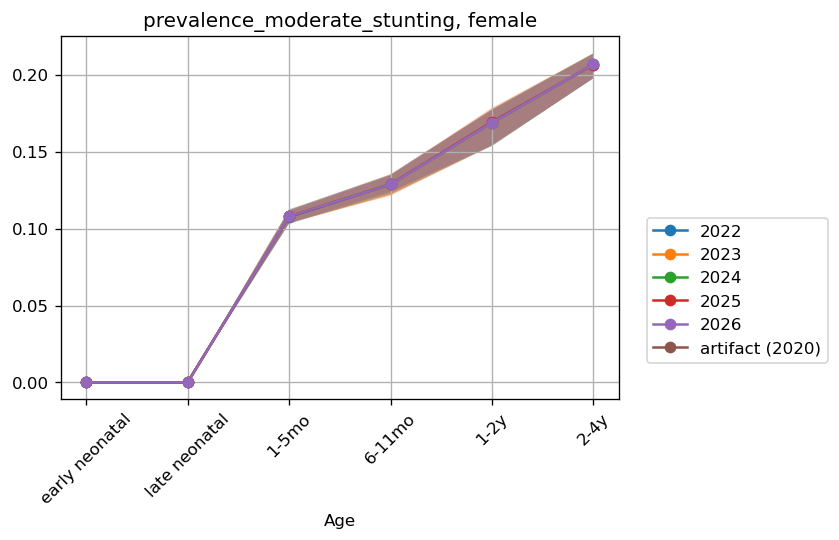

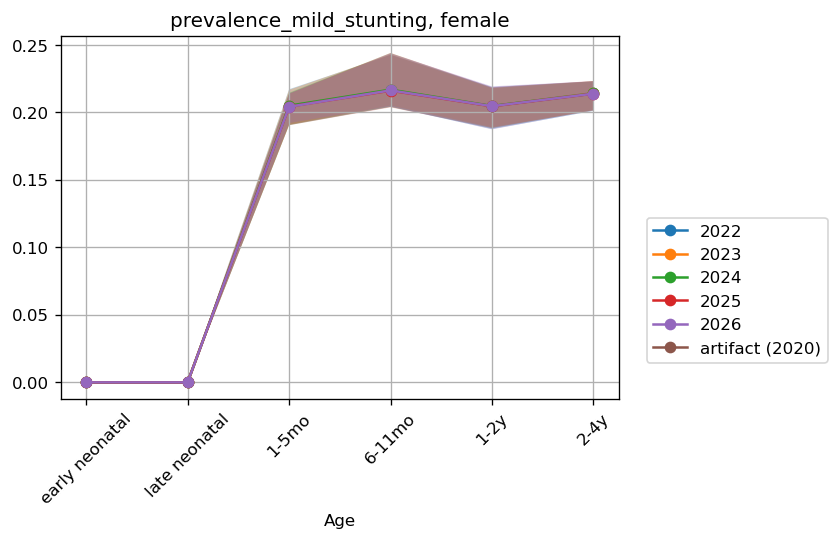

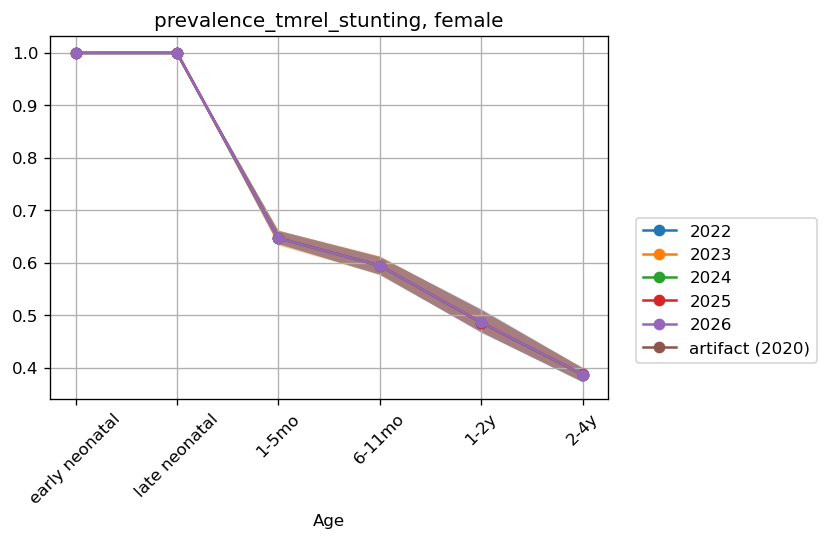

In [57]:
with PdfPages(output_dir + 'stunting_prevalence(filtered_draws).pdf') as pdf:
    for sex in ('male', 'female'):
        for risk_cat in ('severe_stunting', 'moderate_stunting', 'mild_stunting', 'tmrel_stunting'):
            plot_sim_vs_art_stunting(
                sim_stunting_prev.query('risk==@risk_cat'),
                art_stunting_prev.query('risk==@risk_cat'),
                sex = sex,
                sim_measure = f'prevalence_{risk_cat}'
            )
            pdf.savefig(bbox_inches='tight')

In [ ]:
ls /share/scratch/users/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/v2.5_stunting/